In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import math
import random
import numpy as np
from scipy.optimize import minimize

In [2]:
def generate_ansatz(noq, qc, angle):
    depth = noq
    off = 0
    for j in range(depth):
        for i in range(noq):
            qc.ry(angle[off + i], i)
            if (i != 0 and j != (depth - 1)):
                qc.cz(0,i)
        off += i+1

In [3]:
def had_test_b(qc, ancilla_index, gate, noq, angle, b):
    qc.h(ancilla_index)
    generate_ansatz(noq, qc, angle)
    append_A_matrix(qc, gate, ancilla_index)
    generate_B(noq, qc, b)
    qc.h(ancilla_index)

In [4]:
def append_A_matrix(qc, gate, ancilla, start = 0, end = 0):
    if (end == 0):
        end = len(gate)
    for i in range(start, end):
        if (gate[i - start] == 1):
            qc.cx(ancilla, i)
        if (gate[i - start] == 2):
            qc.cy(ancilla, i)   
        if (gate[i - start] == 3):
            qc.cz(ancilla, i)             

In [5]:
def generate_B(noq, qc, b):
    qc.initialize(b, range(noq))

In [6]:
def had_test_a(qc, ancilla_index, gat, gat_trans, noq, angle, bIm = False):
    qc.h(ancilla_index)
    if (bIm):
        qc.sdg(ancilla_index)
    generate_ansatz(noq, qc, angle)
    append_A_matrix(qc, gat, ancilla_index)
    append_A_matrix(qc, gat_trans, ancilla_index)
    qc.h(ancilla_index)

In [26]:
def generate_control_ansatz(noq, qc, angle, ancilla, reg):
    depth = noq
    off = 0
    for j in range(depth):
        for i in range(noq):
            qc.cry(angle[i+off], qiskit.circuit.Qubit(reg,ancilla), qiskit.circuit.Qubit(reg, i))
            if (i != 0 and j != (depth - 1)):
                qc.h(j)
                qc.ccx(ancilla, i, j)
                qc.h(j)
        off += i+1
qc1 = QuantumRegister(3)
qc = QuantumCircuit(qc1)
generate_control_ansatz(2, qc, [0, np.pi/8, np.pi, np.pi/2], 2, qc1)
print(qc)

              ┌───────────┐  ┌───┐┌───────────┐┌───┐┌───┐                  »
q4042_0: |0>──┤ U3(0,0,0) ├──┤ X ├┤ U3(0,0,0) ├┤ X ├┤ H ├──────────────────»
            ┌─┴───────────┴─┐└─┬─┘└───────────┘└─┬─┘├───┤┌────────────────┐»
q4042_1: |0>┤ U3(pi/16,0,0) ├──┼─────────────────┼──┤ X ├┤ U3(-pi/16,0,0) ├»
            └───────────────┘  │                 │  └─┬─┘└────────────────┘»
q4042_2: |0>───────────────────■─────────────────■────■────────────────────»
                                                                           »
«              ┌───┐     ┌───┐      ┌──────────────┐┌───┐┌───────────────┐┌───┐»
«q4042_0: ─────┤ X ├─────┤ H ├──────┤ U3(pi/2,0,0) ├┤ X ├┤ U3(-pi/2,0,0) ├┤ X ├»
«         ┌───┐└─┬─┘┌────┴───┴─────┐└──────────────┘└─┬─┘└───────────────┘└─┬─┘»
«q4042_1: ┤ X ├──■──┤ U3(pi/4,0,0) ├──────────────────┼─────────────────────┼──»
«         └─┬─┘  │  └──────────────┘                  │                     │  »
«q4042_2: ──■────■────────────────────────────────────■─

In [24]:
def hadamard_test_num(noq, qc, angle, ancilla, reg, gate, b):
        qc.h(ancilla)
        qc.barrier()
        generate_control_ansatz(noq, qc, angle, ancilla, reg)
        qc.barrier()
        append_A_matrix(qc, gate, ancilla)
        qc.barrier()
        qc.ch(ancilla, 0)
        qc.ch(ancilla, 1)
        qc.barrier()
        qc.h(ancilla)

qc1 = QuantumRegister(3)
qc = QuantumCircuit(qc1)
angle = [np.pi/2, np.pi/8, np.pi/6, np.pi/3]
a = np.matrix('1 2 3 5; 5 4 3 1; 1 3 3 1; 2 3 4 7')
b = [0.7071067, 0.7071067, 0.7071067, 0.7071067]
a = a/np.linalg.norm(b)
b = b/np.linalg.norm(b)
dec_list = get_arbitary_decomposition(a)
gate = []
coeff = []
for i in range(len(dec_list)):
    if (abs(dec_list[i][0]) != 0):
        coeff.append(dec_list[i][0])
        gate.append(dec_list[i][1])

denom = 0
numer = 0
cof = 0

hadamard_test_num(2, qc, angle, 2, qc1, gate[5], b)
print(qc)

                  ░  ┌──────────────┐┌───┐┌───────────────┐┌───┐     »
q4040_0: |0>──────░──┤ U3(pi/4,0,0) ├┤ X ├┤ U3(-pi/4,0,0) ├┤ X ├─────»
                  ░ ┌┴──────────────┤└─┬─┘└───────────────┘└─┬─┘┌───┐»
q4040_1: |0>──────░─┤ U3(pi/16,0,0) ├──┼─────────────────────┼──┤ X ├»
            ┌───┐ ░ └───────────────┘  │                     │  └─┬─┘»
q4040_2: |0>┤ H ├─░────────────────────■─────────────────────■────■──»
            └───┘ ░                                                  »
«                                   ┌───────────────┐┌───┐┌────────────────┐»
«q4040_0: ────────────────────────■─┤ U3(pi/12,0,0) ├┤ X ├┤ U3(-pi/12,0,0) ├»
«         ┌────────────────┐┌───┐ │ └┬──────────────┤└─┬─┘└────────────────┘»
«q4040_1: ┤ U3(-pi/16,0,0) ├┤ X ├─■──┤ U3(pi/6,0,0) ├──┼────────────────────»
«         └────────────────┘└─┬─┘    └──────────────┘  │                    »
«q4040_2: ────────────────────■────────────────────────■────────────────────»
«                                  

In [9]:
import numpy as np
I = np.asmatrix('1 0;0 1')
X = np.asmatrix('0 1;1 0')
Y = np.asmatrix('0 0-1j;0+1j 0')
Z = np.asmatrix('1 0;0 -1')
pauli_i = [I, 0]
pauli_x = [X, 1]
pauli_y = [Y, 2]
pauli_z = [Z, 3]

def get_basis_set(num_of_qubit = 1):
    basis_set = [pauli_i, pauli_x, pauli_y, pauli_z]
    int_set = [pauli_i, pauli_x, pauli_y, pauli_z]
    temp_set = []
    for i in range (num_of_qubit-1):
        for j in range (len(basis_set)):
            for k in range (len(int_set)):
                a = basis_set[j]
                b = int_set[k]
                #temp_set.append()
                temp_set.append([np.kron(a[0],b[0]),[a[1],b[1]]])
        int_set = temp_set
        #print(int_set)
        temp_set = []
    return int_set

def get_decomposition(A, num_of_q):
    basis = get_basis_set(num_of_q)
    dec_list = []
    for i in range(len(basis)):
        b = basis[i]
        coeff = np.trace(A*b[0])/(2**num_of_q)
        dec_list.append([coeff, b[1]])
    return dec_list
def get_arbitary_decomposition(A):
    size = A.shape
    size = size[0]
    power = math.log2(size)
    p = int(power)
    if (p != power):
        p += 1
    ret = np.zeros([2**p,2**p], dtype = float)
    ret[:size, :size] = A
    for i in range(size, 2**p):
        ret[i,i] = 1
    return get_decomposition(ret, p)

In [ ]:
noq = 2

angle = [np.pi/2, np.pi/8, np.pi/6, np.pi/3]
a = np.matrix('1 2 3 5; 5 4 3 1; 1 3 3 1; 2 3 4 7')
b = [0.7071067, 0.7071067, 0.7071067, 0.7071067]
a = a#/np.linalg.norm(b)
b = b/np.linalg.norm(b)
dec_list = get_arbitary_decomposition(a)
gate = []
coeff = []
for i in range(len(dec_list)):
    if (abs(dec_list[i][0]) != 0):
        coeff.append(dec_list[i][0])
        gate.append(dec_list[i][1])

denom = 0
numer = 0
cof = 0
backend = Aer.get_backend('statevector_simulator')
for i in range(len(coeff)):
    for j in range(len(coeff)):
        circ = QuantumCircuit(noq + 1,1)
        cof = coeff[i]*np.conj(coeff[j])
        had_test_a(circ, noq, gate[i], gate[j], noq, angle)
        circ.measure(noq, 0)
        job = execute(circ, backend)
        result = job.result()
        outputstate = result.get_statevector(circ, decimals=100)
        o = outputstate
        m_sum = 0
        for l in range (0, len(o)):
            if (l%2 == 1):
                n = float(o[l])**2
                m_sum+=n
        denom += cof*m_sum

for i in range(len(coeff)):
    circ = QuantumRegister(noq + 1)
    had_test_b(circ, noq, gate[i], noq, angle, b)
    circ.measure(noq, 0)
    job = execute(circ, backend)
    result = job.result()
    outputstate = result.get_statevector(circ, decimals=100)
    o = outputstate
    m_sum = 0
    for l in range (0, len(o)):
        if (l%2 == 1):
            n = float(o[l])**2
            m_sum+=n
    numer += coeff[i]*m_sum
    
numer *= numer 
print(1-(numer/denom))

In [200]:
a = np.matrix('1 2 3 4; 2 5 1 3; 3 1 6 2; 4 3 2 7')
b = [0.7071067, 0.7071067, 0.7071067, 0.7071067]
d = np.linalg.norm(b)
a = a/(10*d)#/(d)#*np.linalg.norm(a))
b = b/d
print(np.linalg.norm(b), np.linalg.norm(a))
dec_list = get_arbitary_decomposition(a)
gate = []
coeff = []
for i in range(len(dec_list)):
    if (abs(dec_list[i][0]) != 0):
        coeff.append(dec_list[i][0])
        gate.append(dec_list[i][1])
print(coeff)
print(len(coeff))
def calculate_cost(angle):  
    denom = 0
    numer = 0
    cof = 0
    noq = 2
    backend = Aer.get_backend('statevector_simulator')
    for i in range(len(coeff)):
        for k in range(len(coeff)):
            circ = QuantumCircuit(noq + 1,1)
            cof = coeff[i]*np.conj(coeff[k])
            had_test_a(circ, noq, gate[i], gate[k], noq, angle)
            circ.measure(noq, 0)
            job = execute(circ, backend)
            result = job.result()
            outputstate = result.get_statevector(circ, decimals=100)
            o = outputstate
            m_sum = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = float(o[l])**2
                    m_sum+=n
            denom += cof*m_sum
            '''circ = QuantumCircuit(noq + 1,1)
            had_test_a(circ, noq, gate[i], gate[k], noq, angle, True)
            circ.measure(noq, 0)
            job = execute(circ, backend)
            result = job.result()
            outputstate = result.get_statevector(circ, decimals=100)
            o = outputstate
            m_sum = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = float(o[l])**2
                    m_sum+=n
            denom += j*cof*m_sum'''
    
    for i in range(len(coeff)):

        '''qc = QuantumCircuit(2*noq + 1, 1)
        Hadamard_Overlap_Test(qc ,noq, b, angle, gate[i], gate[k])'''
        qc1 = QuantumRegister(2*noq + 1)
        cr = ClassicalRegister(1)
        qc = QuantumCircuit(qc1, cr)
        swap_test(noq, qc, angle, b, 2*noq, gate[i])
        qc.measure(2*noq, 0)
        job = execute(qc, backend)
        result = job.result()
        outputstate = result.get_statevector(qc, decimals=3)
        o = outputstate
        m_sum = 0
        for l in range (0, len(o)):
            if (l%2 == 1):
                n = float(o[l])**2
                m_sum+=n
        m_sum = 2*(m_sum - 0.5)
        numer += m_sum*(coeff[i]*np.conj(coeff[i]))
        '''qc = QuantumCircuit(2*noq + 1, 1)
        Hadamard_Overlap_Test(qc ,noq, b, angle, gate[i], gate[k], True)
        job = execute(qc, backend)
        result = job.result()
        outputstate = result.get_statevector(qc, decimals=100)
        o = outputstate
        m_sum = 0
        for l in range (0, len(o)):
            if (l%2 == 1):
                n = float(o[l])**2
                m_sum+=n
        numer += j*coeff[i]*coeff[k]*m_sum'''
            #print(j*coeff[i]*coeff[k]*m_sum)
    print("numer = "+str(numer)+" denom= "+str(denom)+"cost = "+str(1-(numer/denom))+" angle = "+ str(angle))
    
    return abs(1-(numer/denom))  

1.0 0.9924717760147231
[0.3358757596272246, 0.1414213724746209, -0.08838835779663805, 0.21213205871193133, 0.17677671559327612, (-0.10606602935596567+0j), -0.12374370091529328, -0.053033014677982854]
8


In [170]:
angle = [0, 1, 2, 3]
maxiter = 2000000
iters = 0 
threshold = 0.000047
k=0
out = minimize(calculate_cost, x0=angle, method="cobyla", options={'maxiter':2}, tol = threshold)
print(out)

[[0, 0], [0, 1], [0, 3], [1, 0], [1, 1], [2, 2], [3, 0], [3, 3]]
[0.671751365, 0.28284268, -0.176776675, 0.42426401999999996, 0.35355335, (-0.21213201+0j), -0.24748734499999997, -0.10606600500000002]
numer = (0.9849997738142332+0j) denom= (1.026144478721632+0j)cost = (0.040096405292417314+0j) angle = [0. 1. 2. 3.]
[[0, 0], [0, 1], [0, 3], [1, 0], [1, 1], [2, 2], [3, 0], [3, 3]]
[0.671751365, 0.28284268, -0.176776675, 0.42426401999999996, 0.35355335, (-0.21213201+0j), -0.24748734499999997, -0.10606600500000002]
numer = (0.9849997738142332+0j) denom= (0.6616563422042984+0j)cost = (-0.48868787463401464+0j) angle = [1. 1. 2. 3.]
     fun: 0.040096405292417314
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 2
  status: 2
 success: False
       x: array([0., 1., 2., 3.])


In [11]:
def swap_test(noq, qc, angle, b, ancilla, gate):
    qc.h(ancilla)
    generate_ansatz(noq, qc, angle)
    append_A_matrix_non_control(qc, gate)
    qc.initialize(b, range(noq, 2*noq))
    qc.ccx(noq-1, 2*noq-1, ancilla)
    qc.h(ancilla)
    qc.measure()
qc = QuantumCircuit(5)
#s#wap_test(2, qc, [0, 1, 2, 3], b, 4, [1,2])
print(qc)

        
q_0: |0>
        
q_1: |0>
        
q_2: |0>
        
q_3: |0>
        
q_4: |0>
        


In [18]:
def append_A_matrix_non_control(qc, gate, start = 0, end = 0):
    if (end == 0):
        end = len(gate)
    for i in range(start, end):
        if (gate[i - start] == 1):
            qc.x(i)
        if (gate[i - start] == 2):
            qc.y(i)   
        if (gate[i - start] == 3):
            qc.z(i)             

In [16]:
a = np.matrix('1 2 3 4; 2 5 1 3; 3 1 6 2; 4 3 2 7')
a = a
print(np.linalg.norm(a))
b = np.matrix('0.7071067;0.7071067;0.7071067;0.7071067')
b = b/np.linalg.norm(b)
ans = np.linalg.inv(a)*b
print((ans)/np.linalg.norm(ans))

14.035668847618199
[[-0.31622777]
 [ 0.63245553]
 [ 0.63245553]
 [ 0.31622777]]


In [13]:
def Hadamard_Overlap_Test(qc ,noq, b, angle, gate, gate_trans,bIm = False):
    qc.h(2*noq)
    generate_ansatz(noq, qc, angle)
    append_A_matrix(qc, gate, 2*noq, 0, noq)
    qc.initialize(b, range(noq, 2*noq))
    append_A_matrix(qc, gate_trans, 2*noq, noq, 2*noq)
    qc.barrier()
    for i in range(0, noq):
        qc.h(i)
        qc.ccx(i, noq+i, 2*noq)

    qc.h(2*noq)
    if (bIm):
        qc.rz(np.pi/2, 2*noq)
    #qc.measure(2*noq, 0)
qt = QuantumRegister(5)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qt, cr)
#Hadamard_Overlap_Test(qc ,2, b, angle, gate[1], gate[1],bIm = False)
print(qc)

         
q3_0: |0>
         
q3_1: |0>
         
q3_2: |0>
         
q3_3: |0>
         
q3_4: |0>
         
 c0_0: 0 
         


[ 0.02971+0.j -0.76149+0.j -0.6405 +0.j -0.0949 +0.j]


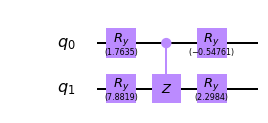

In [27]:
circ = QuantumCircuit(2)
generate_ansatz(2, circ, [1.76348719,  7.8818924 , -0.54760516,  2.29840554])
circ.draw(output="mpl")
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
outputstate = result.get_statevector(circ, decimals=5)
print(outputstate)
circ.draw(output="mpl")

In [28]:
a = np.matrix('1 2 3 4; 2 5 1 3; 3 1 6 2; 4 3 2 7')
b = [0.7071067, 0.7071067, 0.7071067, 0.7071067]
d = np.linalg.norm(b)
a = a/(d)#/(d)#*np.linalg.norm(a))
b = b/d
print(np.linalg.norm(b), np.linalg.norm(a))
dec_list = get_arbitary_decomposition(a)
gate = []
coeff = []
for i in range(len(dec_list)):
    if (abs(dec_list[i][0]) != 0):
        coeff.append(dec_list[i][0])
        gate.append(dec_list[i][1])
print(coeff)
print(len(coeff))
def calculate_cost(angle):  
    shots = 8912
    T = shots
    denom = 0
    numer = 0
    cof = 0
    noq = 2
    backend = Aer.get_backend('qasm_simulator')
    #print(gate)
    #print(coeff)
    for i in range(len(coeff)):
        for k in range(len(coeff)):
            circ = QuantumCircuit(noq + 1,1)
            cof = coeff[i]*np.conj(coeff[k])
            had_test_a(circ, noq, gate[i], gate[k], noq, angle)
            circ.measure(noq, 0)
            job = execute(circ, backend=backend, shots=shots,max_credits=3)    
            result = job.result()
            counts = result.get_counts(circ)
            m_sum = 0
            if "0" in list (counts):
                m_sum=m_sum+counts["0"]/T
            if "1" in list (counts):
                m_sum=m_sum-counts["1"]/T
            denom += cof*m_sum
    
    for i in range(len(coeff)):
        for j in range(len(coeff)):
            qc1 = QuantumRegister(2*noq + 1)
            cr = ClassicalRegister(1)
            qc = QuantumCircuit(qc1, cr)
            #swap_test_a(noq, qc, angle, b, 2*noq, gate[i], gate[j])
            #Hadamard_Overlap_Test(qc ,noq, b, angle, gate[i], gate[j],bIm = False)
            qc.measure(2*noq, 0)
            #print(qc)
            job = execute(qc, backend=backend, shots=shots,max_credits=3)    
            result = job.result()
            counts = result.get_counts(qc)
            m_sum = 0
            #print(counts)
            if "0" in list (counts):
                m_sum=m_sum+counts["0"]/T
            if "1" in list (counts):
                m_sum=m_sum-counts["1"]/T
            numer += m_sum*(coeff[i]*np.conj(coeff[j]))
    print("numer = "+str(numer)+" denom= "+str(denom)+"cost = "+str(1-(numer/denom))+" angle = "+ str(angle))
    
    return abs(1-(numer/denom))  
angle = [2, 4.11, 1, 1.57]
maxiter = 2000000
iters = 0 
threshold = 0.000047
k=0
out = minimize(calculate_cost, x0=angle, method="cobyla", options={'maxiter':200},tol = threshold)
print(out)

1.0 9.924717760147232
[3.3587575962722456, 1.4142137247462088, -0.8838835779663806, 2.121320587119313, 1.767767155932761, (-1.0606602935596565+0j), -1.2374370091529328, -0.5303301467798283]
8
numer = (24.500005625941668+0j) denom= (19.04187207905247+0j)cost = (-0.2866384945886473+0j) angle = [2.   4.11 1.   1.57]
numer = (24.500005625941668+0j) denom= (13.017598646774434+0j)cost = (-0.8820679827928479+0j) angle = [3.   4.11 1.   1.57]
numer = (24.500005625941668+0j) denom= (45.37072546561712+0j)cost = (0.46000410232566635+0j) angle = [2.   5.11 1.   1.57]
numer = (24.500005625941668+0j) denom= (9.312417982218689+0j)cost = (-1.6308962583855724+0j) angle = [2.   4.11 2.   1.57]
numer = (24.500005625941668+0j) denom= (22.079911376319036+0j)cost = (-0.10960615775922955+0j) angle = [2.   4.11 1.   2.57]
numer = (24.500005625941668+0j) denom= (18.40532149526902+0j)cost = (-0.33113706447557845+0j) angle = [1.60064016 3.99372215 0.09839439 2.68873716]
numer = (24.500005625941668+0j) denom= (14

KeyboardInterrupt: 

In [20]:
def swap_test_a(noq, qc, angle, b, ancilla, gate, gate2):
    #qc.h(ancilla)
    generate_ansatz(noq, qc, angle)
    append_A_matrix_non_control(qc, gate)
    qc.initialize(b, range(noq, 2*noq))
    append_A_matrix_non_control(qc, gate2, start = noq, end = 2*noq)
    qc.barrier()
    for i in range(noq, 2*noq):
        qc.cx(i,i-noq)
        qc.h(i)       
        qc.barrier()
    for i in range(0, noq):
        qc.ccx(i, i+noq, ancilla)
        qc.barrier()
    #qc.h(ancilla)
    #qc.measure()
qt = QuantumRegister(5)
qc = QuantumCircuit(qt)
swap_test_a(2, qc, [0, 1, 2, 3], b, 4, [1,2], [2,3])
print(qc)

                      ┌───────┐                 ┌───────┐┌───┐ ░ ┌───┐      ░ »
q455_0: |0>───────────┤ Ry(0) ├──────────────■──┤ Ry(2) ├┤ X ├─░─┤ X ├──────░─»
                      ├───────┤              │  ├───────┤├───┤ ░ └─┬─┘      ░ »
q455_1: |0>───────────┤ Ry(1) ├──────────────■──┤ Ry(3) ├┤ Y ├─░───┼────────░─»
           ┌──────────┴───────┴───────────┐┌───┐└───────┘└───┘ ░   │  ┌───┐ ░ »
q455_2: |0>┤0                             ├┤ Y ├───────────────░───■──┤ H ├─░─»
           │  initialize(0.5,0.5,0.5,0.5) │├───┤               ░      └───┘ ░ »
q455_3: |0>┤1                             ├┤ Z ├───────────────░────────────░─»
           └──────────────────────────────┘└───┘               ░            ░ »
q455_4: |0>────────────────────────────────────────────────────░────────────░─»
                                                               ░            ░ »
«                   ░       ░       ░ 
«q455_0: ───────────░───■───░───────░─
«        ┌───┐      ░   │   ░       ░ 
«q4

In [ ]:
a = np.matrix('1 2 3 4; 2 5 1 3; 3 1 6 2; 4 3 2 7')
b = [0.7071067, 0.7071067, 0.7071067, 0.7071067]
d = np.linalg.norm(b)
a = a/(d)#/(d)#*np.linalg.norm(a))
b = b/d
print(np.linalg.norm(b), np.linalg.norm(a))
dec_list = get_arbitary_decomposition(a)
gate = []
coeff = []
for i in range(len(dec_list)):
    if (abs(dec_list[i][0]) != 0):
        coeff.append(dec_list[i][0])
        gate.append(dec_list[i][1])
print(coeff)
print(len(coeff))
def calculate_cost(angle):  
    shots = 8912
    T = shots
    denom = 0
    numer = 0
    cof = 0
    noq = 2
    backend = Aer.get_backend('qasm_simulator')
    #print(gate)
    #print(coeff)
    for i in range(len(coeff)):
        for k in range(len(coeff)):
            circ = QuantumCircuit(noq + 1,1)
            cof = coeff[i]*np.conj(coeff[k])
            had_test_a(circ, noq, gate[i], gate[k], noq, angle)
            circ.measure(noq, 0)
            job = execute(circ, backend=backend, shots=shots,max_credits=3)    
            result = job.result()
            counts = result.get_counts(circ)
            m_sum = 0
            if "0" in list (counts):
                m_sum=m_sum+counts["0"]/T
            if "1" in list (counts):
                m_sum=m_sum-counts["1"]/T
            denom += cof*m_sum
    
    for i in range(len(coeff)):
        for j in range(len(coeff)):
            qc1 = QuantumRegister(2*noq + 1)
            cr = ClassicalRegister(1)
            qc = QuantumCircuit(qc1, cr)
            #swap_test_a(noq, qc, angle, b, 2*noq, gate[i], gate[j])
            #Hadamard_Overlap_Test(qc ,noq, b, angle, gate[i], gate[j],bIm = False)
            hadamard_test_num()
            qc.measure(2*noq, 0)
            #print(qc)
            job = execute(qc, backend=backend, shots=shots,max_credits=3)    
            result = job.result()
            counts = result.get_counts(qc)
            m_sum = 0
            #print(counts)
            if "0" in list (counts):
                m_sum=m_sum+counts["0"]/T
            if "1" in list (counts):
                m_sum=m_sum-counts["1"]/T
            numer += m_sum*(coeff[i]*np.conj(coeff[j]))
    print("numer = "+str(numer)+" denom= "+str(denom)+"cost = "+str(1-(numer/denom))+" angle = "+ str(angle))
    
    return abs(1-(numer/denom))  
angle = [2, 4, 1, 1.57]
maxiter = 2000000
iters = 0 
threshold = 0.000047
k=0
out = minimize(calculate_cost, x0=angle, method="cobyla", options={'maxiter':200},tol = threshold)
print(out)